S Mamba code: https://github.com/wzhwzhwzh0921/S-D-Mamba/blob/main/model/S_Mamba.py

Mamba code: https://github.com/state-spaces/mamba/blob/main/mamba_ssm/modules/mamba2_simple.py

Graph NN code:https://github.com/pyg-team/pytorch_geometric 

Data Reference: https://www.kaggle.com/datasets/ehoseinz/cnnpred-stock-market-prediction

## Machine Learning (ML) model

NYSE Dataset:
  X_train shape: (1776, 5, 5), y_train shape: (888,)
  X_val shape: (110, 5, 5), y_val shape: (55,)
  X_test shape: (334, 5, 5), y_test shape: (167,)


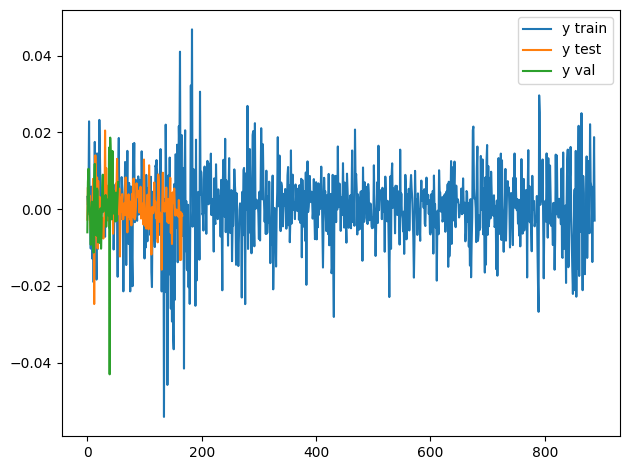

In [1]:
from Utils.Loading_data import labels_plotting, Get_data
from Models.ML_models import run_ML_models

processed_data =  Get_data('Data')
labels_plotting(processed_data)
# run_ML_models()

In [2]:
64/15

4.266666666666667

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AdaptiveGraphConvolutionBlock(nn.Module):
    def __init__(self, node_num, embed_dim, cheb_k, feature_dim, initial_scaling=1.0):
        super(AdaptiveGraphConvolutionBlock, self).__init__()
        self.node_num = node_num  # N
        self.embed_dim = embed_dim  # de
        self.cheb_k = cheb_k  # k
        self.feature_dim = feature_dim  # L

        # Learnable scaling factor ψ
        self.scaling_factor = nn.Parameter(torch.tensor(initial_scaling))
        
        # Learnable node embedding matrix Ψ (N x de)
        self.node_embeddings = nn.Parameter(torch.FloatTensor(node_num, embed_dim))
        
        # Matrix factorization for filter weights WFilter and bias bFilter
        self.Fw = nn.Parameter(torch.FloatTensor(embed_dim, cheb_k + 1, feature_dim))
        self.fb = nn.Parameter(torch.FloatTensor(embed_dim))

        # Initialize parameters
        nn.init.kaiming_uniform_(self.node_embeddings, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.Fw, mode='fan_in', nonlinearity='relu')
        nn.init.constant_(self.fb, 0.01)

    def forward(self, x):
        # Transpose x from (B, L, N) to (B, N, L) to match dimensionality
        x = x.transpose(1, 2)  # Now x is (B, N, L)

        # Calculate pairwise distances using node embeddings Ψ
        dist_matrix = torch.matmul(self.node_embeddings, self.node_embeddings.transpose(0, 1))  # N x N
        pairwise_distance = torch.diag(dist_matrix)[:, None] + torch.diag(dist_matrix)[None, :] - 2 * dist_matrix
        D = torch.exp(-self.scaling_factor * pairwise_distance)
        
        # Normalize adjacency matrix with softmax
        adjacency_matrix = F.softmax(D, dim=1)

        # Chebyshev polynomial approximation
        supports = [torch.eye(self.node_num).to(adjacency_matrix.device), adjacency_matrix]
        for k in range(2, self.cheb_k + 1):
            supports.append(2 * torch.matmul(adjacency_matrix, supports[-1]) - supports[-2])

        # Stack supports as (K+1) x N x N
        supports = torch.stack(supports, dim=0)  # (K+1) x N x N

        # Generate WFilter and bFilter using matrix factorization
        WFilter = torch.einsum('ij,jkl->ikl', self.node_embeddings, self.Fw)  # N x (K+1) x L
        bFilter = torch.matmul(self.node_embeddings, self.fb)  # N

        # Initialize output to zero with shape (B, N)
        output = torch.zeros(x.shape[0], self.node_num).to(x.device)
        
        # Graph convolution operation with adaptive filters
        for k in range(self.cheb_k + 1):
            support_filter_product = torch.matmul(supports[k], WFilter[:, k, :])  # N x L
            
            # Apply convolution across the input x (B, N, L)
            output += torch.einsum('bnl,nl->bn', x, support_filter_product)
        
        # Add bias
        output += bFilter.unsqueeze(0)  # Adjust bias shape for broadcasting
        
        return output


# Define parameters
node_num = 82          # Number of nodes, N
embed_dim = 10          # Embedding dimension, de
cheb_k = 3             # Order of the Chebyshev polynomial, k
feature_dim = 5        # Feature dimension, L
batch_size = 128         # Batch size, B

# Instantiate the AdaptiveGraphConvolutionBlock
agc_block = AdaptiveGraphConvolutionBlock(node_num, embed_dim, cheb_k, feature_dim)

# Generate random sample input: (B, L, N)
sample_input = torch.randn(batch_size, feature_dim, node_num)

# Forward pass
output = agc_block(sample_input)

# Display the output
print("Input shape:", sample_input.shape)
print("Output shape:", output.shape)
print("Output:\n", output)


Input shape: torch.Size([128, 5, 82])
Output shape: torch.Size([128, 82])
Output:
 tensor([[-0.9942,  4.0006, -1.0156,  ..., -1.8983, -0.1012, -0.6194],
        [ 1.1686, -3.7670,  0.7269,  ...,  1.0079, -1.0299,  1.5157],
        [ 2.2978,  0.5683,  0.0697,  ..., -0.1126,  2.5538,  0.4696],
        ...,
        [ 1.0743,  1.9357, -0.5650,  ..., -0.7510, -1.3281, -0.7462],
        [-2.5925, -0.6210,  0.2771,  ...,  1.0317, -1.0451, -1.0107],
        [-2.8029, -1.1115,  0.0232,  ...,  1.5983,  0.0277,  1.6209]],
       grad_fn=<AddBackward0>)


In [26]:
list(range(256, 1025, 256))

[256, 512, 768, 1024]